Importing the necessaries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.ensemble import IsolationForest
from datasets import load_dataset
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score
from sklearn.metrics import multilabel_confusion_matrix
import torch
import xgboost as xgb

c:\root\Projects\python\opjustice-lm\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading the dataset from disk

In [2]:
train_dataset = load_dataset('rootblind/opjustice-dataset', split='train')
test_dataset = load_dataset('rootblind/opjustice-dataset', split='test')

Generating test split: 100%|██████████| 4245/4245 [00:00<00:00, 249716.98 examples/s]


Inspecting data

In [3]:
train_dataset.to_pandas().head()

,Message,OK,Aggro,Violence,Sexual,Hateful
0,mai taci,1,0,0,0,0
1,Cel mai tari om da carry ma carat cu kata sa...,1,0,0,0,0
2,wtf ce smap de bot ratat am vrut sa pun ce fac...,1,0,0,0,0
3,el e in high elo,1,0,0,0,0
4,ai vol iu,1,0,0,0,0


In [4]:
test_dataset.to_pandas().head()

,Message,OK,Aggro,Violence,Sexual,Hateful
0,giorgii,1,0,0,0,0
1,atata timp cat nu dau tag la euneeuw pur si s...,1,0,0,0,0
2,duoq,1,0,0,0,0
3,Ar trebui sa il stii atunci,1,0,0,0,0
4,nu e din ala,1,0,0,0,0


Converting the dataset to pandas for easier analysis

In [5]:
import pandas as pd

df_train = train_dataset.to_pandas()
df_test = test_dataset.to_pandas()

df_train.describe()

,OK,Aggro,Violence,Sexual,Hateful
count,16950.000000,16950.000000,16950.000000,16950.000000,16950.000000
mean,0.467021,0.446195,0.116519,0.192507,0.136519
std,0.498926,0.497111,0.320856,0.394281,0.343349
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
df_test.describe()

,OK,Aggro,Violence,Sexual,Hateful
count,4245.000000,4245.000000,4245.000000,4245.000000,4245.000000
mean,0.467609,0.446408,0.124617,0.187750,0.137102
std,0.499008,0.497178,0.330323,0.390559,0.343996
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16950 entries, 0 to 16949
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Message   16950 non-null  object
 1   OK        16950 non-null  int64 
 2   Aggro     16950 non-null  int64 
 3   Violence  16950 non-null  int64 
 4   Sexual    16950 non-null  int64 
 5   Hateful   16950 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 794.7+ KB


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4245 entries, 0 to 4244
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Message   4245 non-null   object
 1   OK        4245 non-null   int64 
 2   Aggro     4245 non-null   int64 
 3   Violence  4245 non-null   int64 
 4   Sexual    4245 non-null   int64 
 5   Hateful   4245 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 199.1+ KB


In [9]:
df_train.isnull().sum()

Message     0
OK          0
Aggro       0
Violence    0
Sexual      0
Hateful     0
dtype: int64

In [10]:
print('Train shape: ', str(df_train.shape))
print('Test shape: ', str(df_test.shape))

Train shape:  (16950, 6)
Test shape:  (4245, 6)


In [11]:
print(f'Number of duplicated instances in train: {df_train.duplicated().sum()}')
print(f'Number of duplicated instances in test: {df_test.duplicated().sum()}')

Number of duplicated instances in train: 323
Number of duplicated instances in test: 24


In [12]:
numeric_df = df_train.select_dtypes(include=[np.number])

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Display the correlation matrix
print(correlation_matrix)

                OK     Aggro  Violence    Sexual   Hateful
OK        1.000000 -0.840227 -0.288350 -0.407266 -0.349819
Aggro    -0.840227  1.000000  0.142327  0.299837  0.248368
Violence -0.288350  0.142327  1.000000  0.066598  0.092853
Sexual   -0.407266  0.299837  0.066598  1.000000  0.051662
Hateful  -0.349819  0.248368  0.092853  0.051662  1.000000


Data visualization

In [13]:
import matplotlib.pyplot as plt # importing the neccessary library

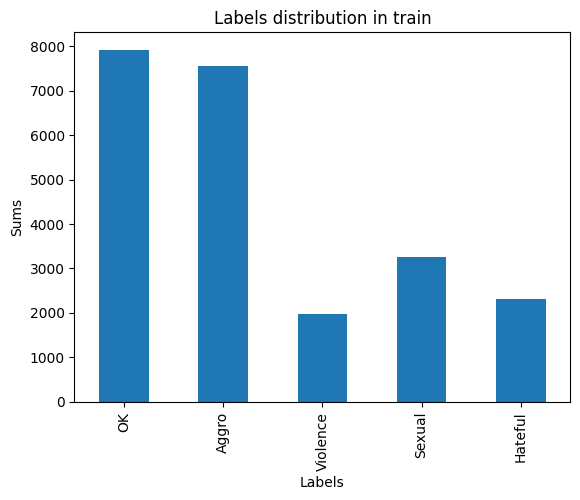

OK          7916
Aggro       7563
Violence    1975
Sexual      3263
Hateful     2314
dtype: int64


In [14]:
columns = df_train.drop(columns='Message')
columns_sums = columns.sum(axis=0)
columns_sums.plot(kind='bar')

plt.title('Labels distribution in train')
plt.ylabel('Sums')
plt.xlabel('Labels')
plt.show()
print(columns_sums)

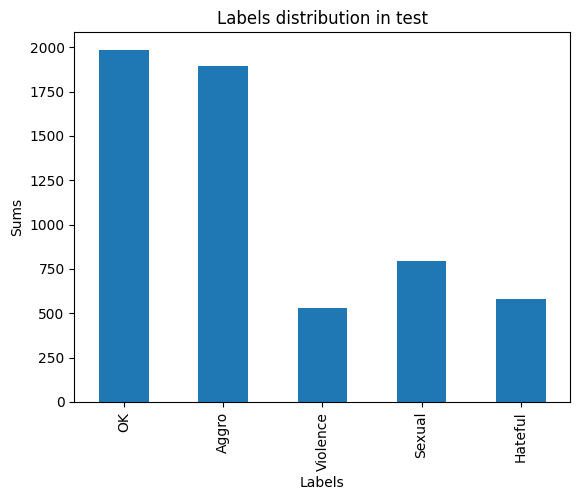

OK          1985
Aggro       1895
Violence     529
Sexual       797
Hateful      582
dtype: int64


In [15]:
columns = df_test.drop(columns='Message')
columns_sums = columns.sum(axis=0)
columns_sums.plot(kind='bar')

plt.title('Labels distribution in test')
plt.ylabel('Sums')
plt.xlabel('Labels')
plt.show()
print(columns_sums)

<Axes: >

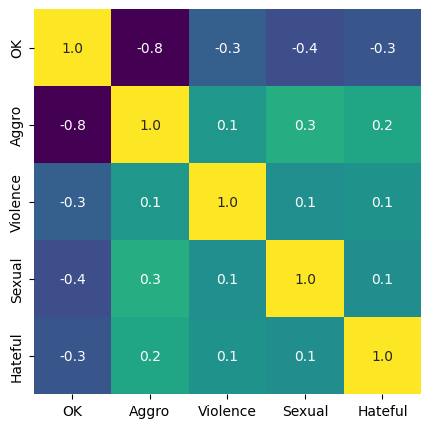

In [16]:
plt.figure(figsize=(5,5))
sns.heatmap(correlation_matrix, annot=True, fmt='.1f', cbar=None,cmap='viridis')

Comparing the train and the test datasets sizes

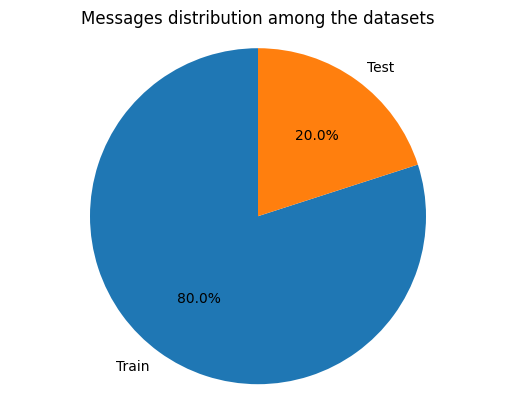

[16950, 4245]


In [17]:
train_test = ['Train', 'Test']
train_test_size = [df_train['Message'].value_counts().sum(), df_test['Message'].value_counts().sum()]
plt.pie(train_test_size, labels=train_test, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Messages distribution among the datasets')
plt.show()
print(train_test_size)

## Model evaluation

In [18]:
accuracy_array = []
models_used = ['opjlm']

### My model

In [19]:
class ToxicityDataset:
    def __init__(self, dataset_path='./automod-model/dataset', dataset_name='rootblind/opjustice-dataset'):
        self.dataset_path = dataset_path
        self.dataset_name = dataset_name
        self.dataset = self.load_dataset()
        self.labels = self.get_labels()
        self.id2label, self.label2id = self.create_label_mappings()

    def load_dataset(self):
        dataset = load_dataset(self.dataset_name)
        return dataset

    def get_labels(self):
        return [label for label in self.dataset['train'].features.keys() if label not in 'Message']

    def create_label_mappings(self):
        id2label = {idx: label for idx, label in enumerate(self.labels)}
        label2id = {label: idx for idx, label in enumerate(self.labels)}
        return id2label, label2id

    def preprocess_data(self, examples, tokenizer):
        text = examples["Message"]
        encoding = tokenizer(text, padding="max_length", truncation=True, max_length=512)
        labels_batch = {k: examples[k] for k in examples.keys() if k in self.labels}
        labels_matrix = np.zeros((len(text), len(self.labels)))

        for idx, label in enumerate(self.labels):
            labels_matrix[:, idx] = labels_batch[label]

        encoding["labels"] = labels_matrix.tolist()
        return encoding

    def encode_dataset(self, tokenizer):
        encoded_dataset = self.dataset.map(lambda x: self.preprocess_data(x, tokenizer), batched=True, remove_columns=self.dataset['train'].column_names)
        encoded_dataset.set_format("torch")
        return encoded_dataset

In [20]:
class ToxicityModel:
    def __init__(self, model_name, num_labels, id2label, label2id, device=None):
        self.model_name = model_name
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = self.load_model(num_labels, id2label, label2id)

    def load_model(self, num_labels, id2label, label2id):
        model = AutoModelForSequenceClassification.from_pretrained(self.model_name, 
                                                                   problem_type="multi_label_classification", 
                                                                   num_labels=num_labels,
                                                                   id2label=id2label,
                                                                   label2id=label2id).to(self.device)
        
        return model

    def predict(self, text, tokenizer):
        encoding = tokenizer(text, return_tensors="pt")
        encoding = {k: v.to(self.device) for k, v in encoding.items()}
        with torch.no_grad():
            outputs = self.model(**encoding)
        
        logits = outputs.logits
        sigmoid = torch.nn.Sigmoid()
        probs = sigmoid(logits.squeeze().cpu())
        predictions = np.zeros(probs.shape)
        predictions[np.where(probs >= 0.5)] = 1
        return predictions

In [21]:
toxicityDataset = ToxicityDataset()
toxicityModel = ToxicityModel(
    model_name='./model_versions/v3', # 8 epochs 16 batch size
    num_labels=len(toxicityDataset.labels),
    id2label=toxicityDataset.id2label,
    label2id=toxicityDataset.label2id
    
    )

In [22]:
tokenizer = AutoTokenizer.from_pretrained('./model_versions/v3')
loaded_dataset = toxicityDataset.load_dataset()
encoded_dataset = toxicityDataset.encode_dataset(tokenizer)

Map: 100%|██████████| 4245/4245 [00:00<00:00, 4455.98 examples/s]


In [23]:
X_test = [sample['Message'] for sample in loaded_dataset['test']]
y_test = [[sample[label] for label in toxicityDataset.labels] for sample in loaded_dataset['test']]

In [24]:
y_pred = [toxicityModel.predict(text, tokenizer) for text in X_test]

c:\root\Projects\python\opjustice-lm\venv\Lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


In [25]:
f1 = f1_score(y_test, y_pred, average="micro")
precision = precision_score(y_test, y_pred, average="micro")
recall = recall_score(y_test, y_pred, average="micro")
accuracy = accuracy_score(y_test, y_pred)
accuracy_array.append(accuracy)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")

F1 Score: 0.9334260385885624
Precision: 0.9391395592864638
Recall: 0.927781617138908
Accuracy: 0.8739693757361602
ROC AUC: 0.9429842964264138


In [26]:
multilabel_confusion_matrix(y_test, y_pred)

array([[[2163,   97],
        [ 130, 1855]],

       [[2244,  106],
        [  94, 1801]],

       [[3645,   71],
        [  94,  435]],

       [[3421,   27],
        [  48,  749]],

       [[3616,   47],
        [  52,  530]]], dtype=int64)

### Setting Xs and ys

In [27]:
# calling the vectorizer to encode the announcements
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(df_train['Message'])
y_train = df_train.drop(columns='Message')
print(X_train.shape)

(16950, 31288)


In [28]:
X_test = vectorizer.transform(df_test['Message'])
y_test = df_test.drop(columns='Message')

X_test.shape

(4245, 31288)

### Isolation Forest

In [29]:
clf =  IsolationForest(n_estimators=50, max_samples="auto", random_state=42, contamination=float(0.1))

from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_train_2d = pca.fit_transform(X_train.toarray())

clf.fit(X_train_2d)

IsolationForest(contamination=0.1, n_estimators=50, random_state=42)

In [30]:
df_train['scores'] = clf.decision_function(X_train_2d)
df_train['anomaly'] = clf.predict(X_train_2d)

df_train.head(20)

,Message,OK,Aggro,Violence,Sexual,Hateful,scores,anomaly
0,mai taci,1,0,0,0,0,0.105604,1
1,Cel mai tari om da carry ma carat cu kata sa...,1,0,0,0,0,0.082860,1
2,wtf ce smap de bot ratat am vrut sa pun ce fac...,1,0,0,0,0,0.137905,1
3,el e in high elo,1,0,0,0,0,0.149029,1
4,ai vol iu,1,0,0,0,0,0.138128,1
5,player exceptional,1,0,0,0,0,0.176269,1
6,a durat cv,1,0,0,0,0,0.177292,1
7,Same,1,0,0,0,0,0.169401,1
8,de unde stii ca i fata,1,0,0,0,0,0.133085,1
9,rateaz q ul ca tine,1,0,0,0,0,0.120641,1


In [31]:
anomaly = df_train.loc[df_train['anomaly'] == -1]
anomaly_index = list(anomaly.index)
print(anomaly)

                                                 Message  OK  Aggro  Violence  \
23                                                  n am   1      0         0   
25      e ok bro nu e ca si cum ai fi tu un mare jucator   1      0         0   
37                     si nu mai merg la scoala de 2 ani   1      0         0   
47                                           ti am zis o   1      0         0   
61                                          nu l inchizi   1      0         0   
...                                                  ...  ..    ...       ...   
16875                                               pula   0      0         0   
16876                             ca merge sa scriu pula   0      0         0   
16877                                          pula pula   0      0         0   
16879                                 maxim ne sugi pula   0      1         0   
16912  afla ca restul candidatilor mai putin nicusor ...   1      0         0   

       Sexual  Hateful    s

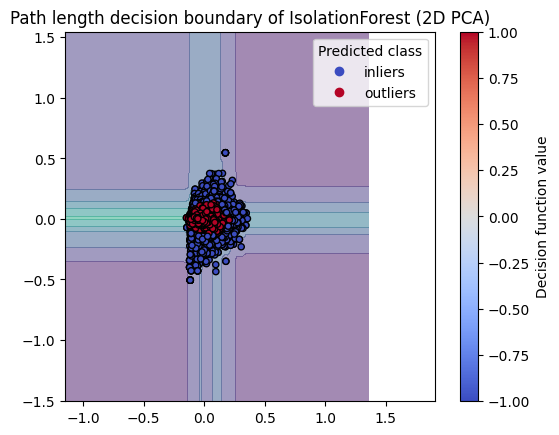

In [32]:
disp = DecisionBoundaryDisplay.from_estimator(
    clf,
    X_train_2d,
    response_method="decision_function",
    alpha=0.5,
)

y_pred = clf.predict(X_train_2d)  # -1 for outliers, 1 for inliers
scatter = disp.ax_.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_pred, cmap="coolwarm", s=20, edgecolor="k")

disp.ax_.set_title("Path length decision boundary of IsolationForest (2D PCA)")
plt.axis("square")

# Legend for predicted classes
plt.legend(handles=scatter.legend_elements()[0], labels=["inliers", "outliers"], title="Predicted class")

# Add a color bar for the decision boundary
plt.colorbar(disp.ax_.collections[1], ax=disp.ax_, label="Decision function value")

plt.show()

df_train.drop(columns=['scores', 'anomaly'], inplace=True)

### Other algorithms

In [33]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
multi_target_model = MultiOutputClassifier(xgb_model)
multi_target_model.fit(X_train, y_train)

MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...))

In [34]:
y_pred = multi_target_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy_array.append(accuracy)
models_used.append('XGBClassifier')
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.73
              precision    recall  f1-score   support

           0       0.83      0.93      0.88      1985
           1       0.92      0.83      0.87      1895
           2       0.97      0.51      0.67       529
           3       0.98      0.70      0.82       797
           4       0.98      0.55      0.71       582

   micro avg       0.89      0.79      0.84      5788
   macro avg       0.94      0.71      0.79      5788
weighted avg       0.91      0.79      0.83      5788
 samples avg       0.85      0.81      0.82      5788



c:\root\Projects\python\opjustice-lm\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [35]:
model = MultiOutputClassifier(RandomForestClassifier())
model.fit(X_train, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier())

In [36]:
y_pred = model.predict(X_test.toarray())
accuracy = accuracy_score(y_test, y_pred)
accuracy_array.append(accuracy)
models_used.append('R.Forest')
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.74
              precision    recall  f1-score   support

           0       0.89      0.83      0.86      1985
           1       0.85      0.88      0.86      1895
           2       0.97      0.57      0.72       529
           3       1.00      0.76      0.86       797
           4       0.99      0.64      0.78       582

   micro avg       0.90      0.79      0.84      5788
   macro avg       0.94      0.74      0.82      5788
weighted avg       0.91      0.79      0.84      5788
 samples avg       0.85      0.80      0.82      5788



c:\root\Projects\python\opjustice-lm\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [37]:
model = MultiOutputClassifier(GaussianNB())
model.fit(X_train.toarray(), y_train)

MultiOutputClassifier(estimator=GaussianNB())

In [38]:
y_pred = model.predict(X_test.toarray())
accuracy = accuracy_score(y_test, y_pred)
accuracy_array.append(accuracy)
models_used.append('GaussianNB')
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.41
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1985
           1       0.88      0.84      0.86      1895
           2       0.21      0.72      0.33       529
           3       0.30      0.81      0.44       797
           4       0.25      0.79      0.38       582

   micro avg       0.50      0.83      0.62      5788
   macro avg       0.50      0.81      0.57      5788
weighted avg       0.66      0.83      0.70      5788
 samples avg       0.62      0.84      0.66      5788



c:\root\Projects\python\opjustice-lm\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [39]:
model = MultiOutputClassifier(DecisionTreeClassifier())
model.fit(X_train, y_train)

MultiOutputClassifier(estimator=DecisionTreeClassifier())

In [40]:
y_pred = model.predict(X_test.toarray())
accuracy = accuracy_score(y_test, y_pred)
accuracy_array.append(accuracy)
models_used.append('DT')
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.68
              precision    recall  f1-score   support

           0       0.84      0.76      0.80      1985
           1       0.78      0.85      0.81      1895
           2       0.82      0.75      0.79       529
           3       0.89      0.85      0.87       797
           4       0.88      0.86      0.87       582

   micro avg       0.83      0.81      0.82      5788
   macro avg       0.84      0.81      0.83      5788
weighted avg       0.83      0.81      0.82      5788
 samples avg       0.78      0.80      0.78      5788



c:\root\Projects\python\opjustice-lm\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [41]:
model = MultiOutputClassifier(LogisticRegression())
model.fit(X_train, y_train)

MultiOutputClassifier(estimator=LogisticRegression())

In [42]:
y_pred = model.predict(X_test.toarray())
accuracy = accuracy_score(y_test, y_pred)
accuracy_array.append(accuracy)
models_used.append('LR')
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.65
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1985
           1       0.89      0.86      0.88      1895
           2       0.92      0.22      0.36       529
           3       0.94      0.52      0.67       797
           4       0.95      0.31      0.47       582

   micro avg       0.89      0.70      0.78      5788
   macro avg       0.91      0.56      0.65      5788
weighted avg       0.90      0.70      0.76      5788
 samples avg       0.83      0.75      0.77      5788



c:\root\Projects\python\opjustice-lm\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Comparing accuracy between algorithms

<BarContainer object of 6 artists>

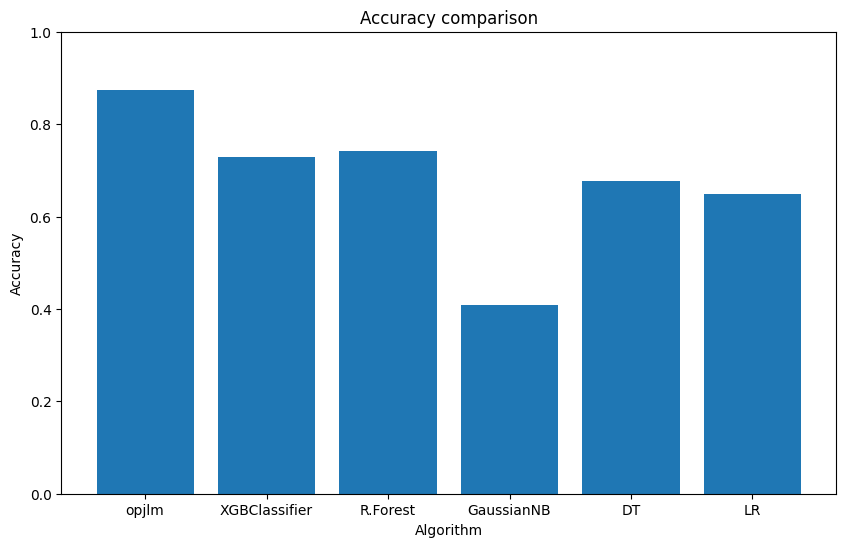

In [43]:
plt.figure(figsize=(10,6))
plt.title('Accuracy comparison')
plt.xlabel('Algorithm')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.bar(models_used, accuracy_array)

It takes over 8GB of RAM just to fit the model, run this cell when you don't need your computer for several minutes.

In [44]:
"""
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
kernel = DotProduct() + WhiteKernel()
model = GaussianProcessRegressor(kernel=kernel, random_state=42)

model.fit(X_train.toarray(), y_train)
y_pred = model.predict(X_test.toarray())
y_pred_binary = (y_pred > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred_binary)
accuracy_array.append(accuracy)
models_used.append('GPR')
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred_binary))
"""

"\nfrom sklearn.gaussian_process.kernels import DotProduct, WhiteKernel\nkernel = DotProduct() + WhiteKernel()\nmodel = GaussianProcessRegressor(kernel=kernel, random_state=42)\n\nmodel.fit(X_train.toarray(), y_train)\ny_pred = model.predict(X_test.toarray())\ny_pred_binary = (y_pred > 0.5).astype(int)\naccuracy = accuracy_score(y_test, y_pred_binary)\naccuracy_array.append(accuracy)\nmodels_used.append('GPR')\nprint(f'Accuracy: {accuracy:.2f}')\nprint(classification_report(y_test, y_pred_binary))\n"